In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

import sys
sys.path.append("..")
import models
import h5py
import data
import inference


%load_ext autoreload
%autoreload 2

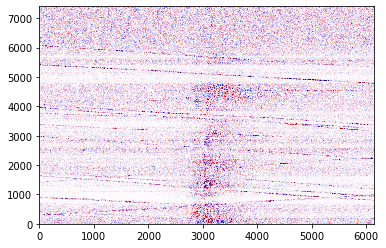

In [2]:
fs = 50.0

file = '../data/preprocessed/real_test/2023p181489.h5'
idx = 6250
#indices = [6250,5250,5500,6250,6750,7250]

with h5py.File(file, 'r') as hf:
    samples = hf['DAS'][81:,idx-3072:idx+3072]

gutter = 1000
x = np.pad(samples[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
x = x / x.std(axis=-1, keepdims=True)
np.save('../data/2023p181489_input.npy', x)

plt.imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

In [3]:
if not os.path.isfile('../data/2023p181489_output.npy'):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-finetuned4-complement-128x512-16x180_200.pt'))
    model.eval()

    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 128, 512, 16, nx_stride=6, nt_stride=50, batch_size=128, dx=4, verbose=False)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p181489_output.npy', rec_filt)

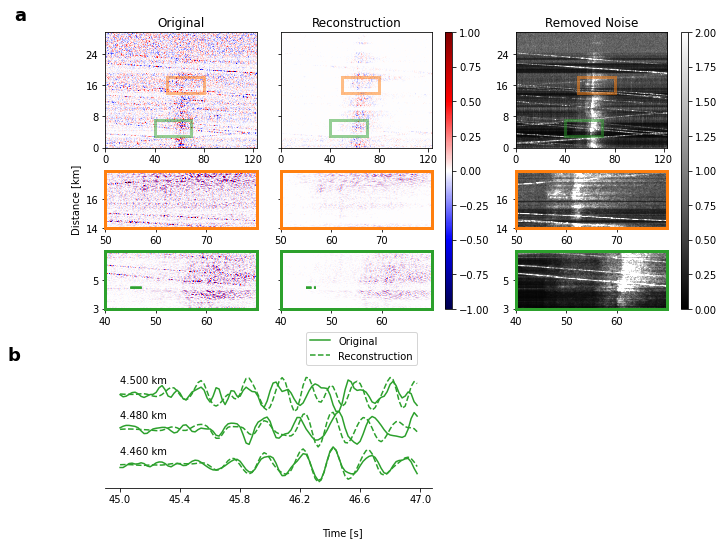

In [4]:
xx = np.load('../data/2023p181489_output.npy')

x1, y1 = 2500, 14000 // 4
x2, y2 = 2000, 3000 // 4
w, h = 1500, 4000 // 4

lw = 3
alpha = 0.5

fig, axs = plt.subplot_mosaic([['a', 'b', 'a1'], 
                                ['a', 'b', 'a1'], 
                                ['c', 'd', 'a2'], 
                                ['e', 'f', 'a3'],
                                ['aa', 'aa', '_'],
                                ['aa', 'aa', '_']],
                                layout='constrained', figsize=(10,7))

vmin = -1
vmax = 1
im = axs['a'].imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['a'].set_title('Original')
im = axs['b'].imshow(xx, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['b'].set_title('Reconstruction')
axs['a'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['b'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['a'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['b'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['c'].imshow(x[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['d'].imshow(xx[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['e'].imshow(x[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['f'].imshow(xx[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=[axs['b'], axs['d'], axs['f']], location='right', shrink=1, aspect=40, pad=0.05)

vmin = 0
vmax = 2
im = axs['a1'].imshow(np.abs(x-xx), origin='lower', interpolation='antialiased', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
axs['a1'].set_title('Removed Noise')
axs['a1'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['a1'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['a2'].imshow(np.abs(x-xx)[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
axs['a3'].imshow(np.abs(x-xx)[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=[axs['a1'], axs['a2'], axs['a3']], location='right', shrink=1, aspect=40, pad=0.05)

axs['c'].set_xticks([i for i in range(0,w,500)])
axs['d'].set_xticks([i for i in range(0,w,500)])
axs['e'].set_xticks([i for i in range(0,w,500)])
axs['f'].set_xticks([i for i in range(0,w,500)])

axs['a'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x * 4 * 0.001))}')) # 4.083809535485629
axs['a1'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x * 4 * 0.001))}'))
axs['a'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
axs['b'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
axs['a1'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))

axs['c'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y1) * 4 * 0.001))}'))
axs['e'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y2) * 4 * 0.001))}'))
axs['a2'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y1) * 4 * 0.001))}'))
axs['a3'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y2) * 4 * 0.001))}'))

axs['c'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['d'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['e'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))
axs['f'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))
axs['a2'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['a3'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))

for a in ['c', 'd', 'a2']:
    for b in ['bottom', 'top', 'right', 'left']:
        axs[a].spines[b].set_color('tab:orange')
        axs[a].spines[b].set_linewidth(lw)
for a in ['e', 'f', 'a3']:
    for b in ['bottom', 'top', 'right', 'left']:
        axs[a].spines[b].set_color('tab:green')
        axs[a].spines[b].set_linewidth(lw)

axs['b'].set_yticklabels([])
axs['d'].set_yticklabels([])
axs['f'].set_yticklabels([])

t11 = 45
t12 = 47

ch1 = 4500//4
ch2 = 4480//4
ch3 = 4460//4

axs['e'].plot([(t11-40)*50, (t12-40)*50], [ch1-y2, ch1-y2], ls="-", c="tab:green")
axs['f'].plot([(t11-40)*50, (t12-40)*50], [ch1-y2, ch1-y2], ls="--", c="tab:green")
axs['e'].plot([(t11-40)*50, (t12-40)*50], [ch2-y2, ch2-y2], ls="-", c="tab:green")
axs['f'].plot([(t11-40)*50, (t12-40)*50], [ch2-y2, ch2-y2], ls="--", c="tab:green")
axs['e'].plot([(t11-40)*50, (t12-40)*50], [ch3-y2, ch3-y2], ls="-", c="tab:green")
axs['f'].plot([(t11-40)*50, (t12-40)*50], [ch3-y2, ch3-y2], ls="--", c="tab:green")

axs['aa'].annotate('{:.3f} km'.format(ch1 * 4 / 1000), (0,0.6))
axs['aa'].plot(x[ch1,t11*50:t12*50] / np.max(np.abs(x[ch1,t11*50:t12*50])), ls="-", c="tab:green", label='Original')
axs['aa'].plot(xx[ch1,t11*50:t12*50] / np.max(np.abs(xx[ch1,t11*50:t12*50])), ls="--", c="tab:green", label='Reconstruction')

axs['aa'].annotate('{:.3f} km'.format(ch2 * 4 / 1000), (0,0.6-2))
axs['aa'].plot(x[ch2,t11*50:t12*50] / np.max(np.abs(x[ch2,t11*50:t12*50])) - 2, ls="-", c="tab:green")
axs['aa'].plot(xx[ch2,t11*50:t12*50] / np.max(np.abs(xx[ch2,t11*50:t12*50])) - 2, ls="--", c="tab:green")
axs['aa'].annotate('{:.3f} km'.format(ch3 * 4 / 1000), (0,0.6-4))
axs['aa'].plot(x[ch3,t11*50:t12*50] / np.max(np.abs(x[ch3,t11*50:t12*50])) - 4, ls="-", c="tab:green")
axs['aa'].plot(xx[ch3,t11*50:t12*50] / np.max(np.abs(xx[ch3,t11*50:t12*50])) - 4, ls="--", c="tab:green")

#axs['aa'].set_ylim((-1,1))
axs['aa'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{((x + t11*50) / 50)}'))
axs['aa'].legend(loc='lower left', bbox_to_anchor=(0.6, 1.02))
axs['aa'].set_yticks([])

axs['c'].set_ylabel('Distance [km]')


axs['_'].axis('off')

axs['a'].text(-0.6, 1.1, 'a', transform=axs['a'].transAxes, size=18, weight='bold')
axs['aa'].text(-0.3, 1.1, 'b', transform=axs['aa'].transAxes, size=18, weight='bold')

axs['aa'].spines[['left', 'top', 'right']].set_visible(False)


#fig.text(0.05, 0.55, 'Distance [km]', ha='left', va='center', rotation='vertical')
fig.text(0.475, -0.05, 'Time [s]', ha='center', va='center')

plt.savefig('./out/figure_08.pdf', bbox_inches='tight', dpi=200)
plt.show()